# Analyze conformational entropy, as computed by CREST / GFN2 across a large molecular test set

This notebook is intended to be used in JupyterLab. YMMV

In [1]:
from __future__ import print_function

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")

from scipy import constants

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

We'll read in the combined CSV, including subset name, filename, SMILES, computational entropy, and a variety of descriptors generated by RDKit

In [2]:
df = pd.read_csv("total-entropy.csv")
# drop inf and nan (i.e. some molecules from COD don't have Gasteiger charges)
df.replace([np.inf, -np.inf], np.nan)
df.dropna(inplace=True)
print(len(df.index))
# 88712 molecules left
#  (technically we should check to make sure all the SMILES are unique!)

88712


In [3]:
# what do we have
print(df.columns)
df = df.astype({"NumAtoms": int, "NumBonds": int, "NumRotors": int, "NumMethyl": int, "NumAmine": int, "NumHydroxyl": int, "HDonors": int, "HAcceptors": int, "RingCount": int, "NumAromaticRings": int})
df.describe()

Index(['Category', 'File', 'SMILES', 'ConfEntropy', 'VibEntropy', 'RotEntropy',
       'TransEntropy', 'NumAtoms', 'NumBonds', 'ExactMolWt', 'NumRotors',
       'NumMethyl', 'NumAmine', 'NumHydroxyl', 'HDonors', 'HAcceptors',
       'RingCount', 'NumAromaticRings', 'MaxAbsPartialChg', 'MinAbsPartialChg',
       'MaxPartialChg', 'MinPartialChg', 'TPSA', 'LabuteASA', 'MolMR',
       'MolLogP', 'EState_VSA1', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4',
       'EState_VSA5', 'HallKierAlpha', 'BertzCT', 'BalabanJ', 'Ipc', 'Kappa1',
       'Kappa2', 'Kappa3', 'FractionCSP3', 'Asphericity', 'Eccentricity',
       'InertialShapeFactor', 'RadiusOfGyration', 'SpherocityIndex',
       'ConfUnder1', 'ConfUnder2', 'ConfUnder3', 'ConfUnder4', 'ConfUnder5',
       'ConfUnder6'],
      dtype='object')


,ConfEntropy,VibEntropy,RotEntropy,TransEntropy,NumAtoms,NumBonds,ExactMolWt,NumRotors,NumMethyl,NumAmine,...,Eccentricity,InertialShapeFactor,RadiusOfGyration,SpherocityIndex,ConfUnder1,ConfUnder2,ConfUnder3,ConfUnder4,ConfUnder5,ConfUnder6
count,88712.000000,88712.000000,88712.000000,88712.000000,88712.000000,88712.000000,88712.000000,88712.000000,88712.000000,88712.000000,...,88712.000000,88712.000000,88712.000000,88712.000000,88712.000000,88712.000000,88712.000000,88712.000000,88712.000000,88712.000000
mean,34.518116,335.711920,126.583734,155.288868,29.702295,32.686491,416.567105,4.700999,2.342614,0.139733,...,0.945846,0.000873,4.340196,0.175237,7.488513,19.718832,37.287199,59.144434,84.382789,112.166697
std,11.888482,191.472141,53.971271,65.657082,8.522830,9.895778,115.286835,2.662111,2.103355,0.439941,...,0.059418,0.001613,0.962407,0.135554,11.658662,31.687167,59.194407,92.263867,130.265784,170.981740
min,0.004000,0.000000,0.000000,0.000000,4.000000,3.000000,58.078250,0.000000,0.000000,0.000000,...,0.169475,0.000013,1.231888,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,27.137750,217.575322,138.774912,177.740504,24.000000,26.000000,344.246378,3.000000,1.000000,0.000000,...,0.921870,0.000314,3.678901,0.081564,2.000000,4.000000,6.000000,8.000000,10.000000,12.000000
50%,36.132000,379.913476,149.569632,183.522792,31.000000,34.000000,428.256274,4.000000,2.000000,0.000000,...,0.966418,0.000533,4.329497,0.141898,4.000000,10.000000,18.000000,27.000000,38.000000,48.000000
75%,43.055000,466.756580,153.824760,185.155598,35.000000,39.000000,481.119523,6.000000,3.000000,0.000000,...,0.988127,0.000900,4.978479,0.233743,9.000000,23.000000,45.000000,73.000000,106.000000,144.000000
max,68.287000,1659.328376,196.346752,203.702224,131.000000,192.000000,2039.240573,20.000000,26.000000,8.000000,...,0.999999,0.162280,12.050900,0.989008,495.000000,981.000000,1403.000000,1822.000000,2410.000000,3693.000000


The goal is to understand how the computed conformational entropies change with molecular structure (e.g., number of rotatable bonds).

First off, let's try the formula from "Large-scale calculations of gas phase thermochemistry: Enthalpy of formation, standard entropy, and heat capacity"
*J. Chem. Phys.* 145 art. 114305 (2016); https://doi.org/10.1063/1.4962627

$$ S_{conf} = R \times (\textrm{Number of Rotors})$$

In [4]:
import sklearn
from sklearn.metrics import mean_absolute_error

pred = constants.R * df['NumRotors']
print(mean_absolute_error(df['ConfEntropy'], pred))

16.03135958921228


Not very good - 16.0 J/mol*K

What does the data look like - comparing entropy against the # of rotatable bonds?

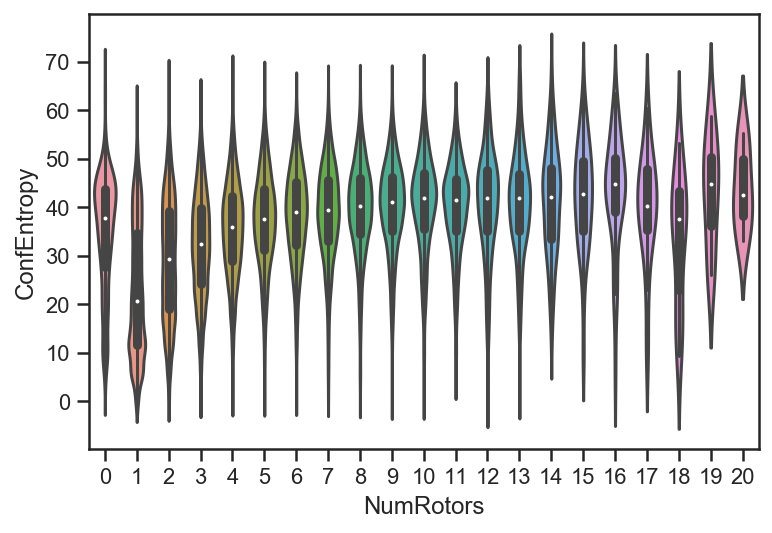

In [5]:
sns.violinplot(x="NumRotors", y="ConfEntropy", data=df)

Clearly entropy isn't very linear with the number of rotatable bonds - but perhaps we can get better error with a full linear model

In [6]:
lm = ols('ConfEntropy~NumRotors', data=df).fit()
print(lm.summary())
print('mean absolute error:', mean_absolute_error(df['ConfEntropy'], lm.fittedvalues))

                            OLS Regression Results                            
Dep. Variable:            ConfEntropy   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                 1.485e+04
Date:                Tue, 08 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:02:03   Log-Likelihood:            -3.3862e+05
No. Observations:               88712   AIC:                         6.773e+05
Df Residuals:                   88710   BIC:                         6.773e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.5682      0.075    354.381      0.0

Nice, we've dropped the MAE from 16.0 J/mol•K to 8.9 J/mol•K - although clearly this isn't a great model either

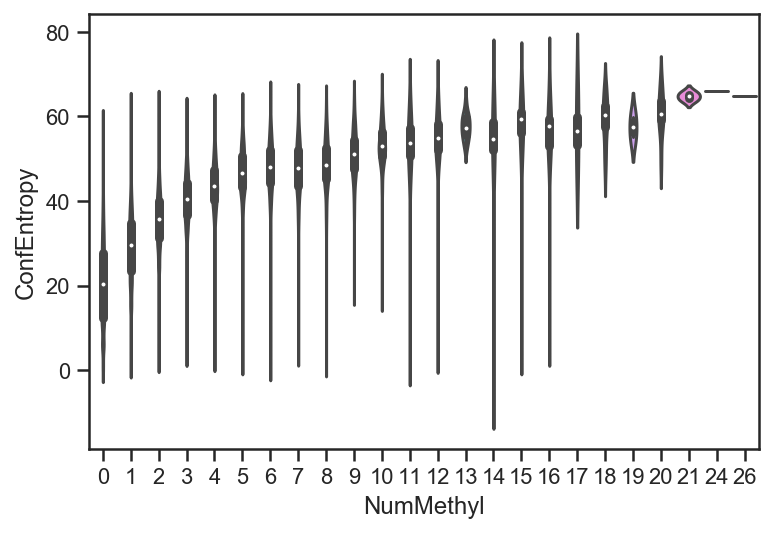

In [7]:
sns.violinplot(x="NumMethyl", y="ConfEntropy", data=df)

The # of methyl groups seems to have a much better prediction of conformational entropy

In [8]:
lm = ols('ConfEntropy~NumRotors+NumMethyl', df).fit()
print(lm.summary())
print('mean absolute error:', mean_absolute_error(df['ConfEntropy'], lm.fittedvalues))

                            OLS Regression Results                            
Dep. Variable:            ConfEntropy   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                 6.276e+04
Date:                Tue, 08 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:02:03   Log-Likelihood:            -3.0638e+05
No. Observations:               88712   AIC:                         6.128e+05
Df Residuals:                   88709   BIC:                         6.128e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.6701      0.057    346.685      0.0

In [9]:
lm = ols('ConfEntropy~np.log(NumRotors+1)+np.log(NumMethyl+1)', df).fit()
print(lm.summary())
print('mean absolute error:', mean_absolute_error(df['ConfEntropy'], lm.fittedvalues))

                            OLS Regression Results                            
Dep. Variable:            ConfEntropy   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                 9.003e+04
Date:                Tue, 08 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:02:03   Log-Likelihood:            -2.9632e+05
No. Observations:               88712   AIC:                         5.926e+05
Df Residuals:                   88709   BIC:                         5.927e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                10.94

Okay, so this new model drops the MAE down to 5.3 J/mol•K which is almost a third of the initial model
What other factors are relevant? We have to tune the formula, because some columns (descriptors) cause errors in statsmodel - likely the values have errors - but none of these are expected to be important based on chemistry intutiton anyway. 

Once we have the (large) formula, we can use LASSO or similar regularization procedures to remove factors. We'll try a range of different penalities to find one with the lowest mean absolute error.

In [14]:
formula = 'ConfEntropy~np.log(NumRotors+1)+np.log(NumMethyl+1)+' + '+'.join(df.columns[7:18]) + '+' + '+'.join(df.columns[22:26]) + '+' + '+'.join(df.columns[31:-6])
print(formula)

ConfEntropy~np.log(NumRotors+1)+np.log(NumMethyl+1)+NumAtoms+NumBonds+ExactMolWt+NumRotors+NumMethyl+NumAmine+NumHydroxyl+HDonors+HAcceptors+RingCount+NumAromaticRings+TPSA+LabuteASA+MolMR+MolLogP+HallKierAlpha+BertzCT+BalabanJ+Ipc+Kappa1+Kappa2+Kappa3+FractionCSP3+Asphericity+Eccentricity+InertialShapeFactor+RadiusOfGyration+SpherocityIndex


In [15]:
max_mae = 10.0
best_alpha = 0
for a in range(100):
    lm = ols(formula, df).fit_regularized(alpha=float(a)/100.0)
    mae = mean_absolute_error(df['ConfEntropy'], lm.fittedvalues)
    if mae < max_mae:
        best_alpha = float(a)/100.0
        max_mae = mae
        print('best so far', best_alpha, max_mae)

lm = ols(formula,df).fit_regularized(alpha=best_alpha)
print(lm.params)

best so far 0.0 5.1405292996290495
best so far 0.01 5.135606721230999
Intercept                28.619484
np.log(NumRotors + 1)     5.216868
np.log(NumMethyl + 1)     9.671547
NumAtoms                 -0.314362
NumBonds                  0.000237
ExactMolWt               -0.003346
NumRotors                -0.168009
NumMethyl                 1.070310
NumAmine                  0.868004
NumHydroxyl               0.480312
HDonors                  -0.908457
HAcceptors                0.224741
RingCount                -0.398141
NumAromaticRings          0.329099
TPSA                     -0.008028
LabuteASA                -0.000935
MolMR                    -0.004618
MolLogP                   0.403724
HallKierAlpha            -0.996169
BertzCT                  -0.001003
BalabanJ                 -3.776429
Ipc                       0.000000
Kappa1                    0.243557
Kappa2                    0.001927
Kappa3                    0.343842
FractionCSP3              2.481425
Asphericity         

Clearly many of these factors are removed by LASSO. We'll create a smaller subset of factors to compare with our initial model

In [ ]:
lm = ols('ConfEntropy~np.log(NumRotors+1)+np.log(NumMethyl+1)+HDonors+HAcceptors+RingCount+MolLogP', df).fit()
print(mean_absolute_error(df['ConfEntropy'], lm.fittedvalues))
print(lm.summary())

These new factors add some minor corrections, improving the mean absolute error from ~5.3 J/mol•K to ~5.1 J/mol•K. More importantly, the new model suggests that hydrogen-bonding groups change the entropy (not surprising, since intramolecular hydrogen bonds would decrease the flexibility), and a molecules with more rings tend to yield lower conformational entropy.

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin

class SMFormulaWrapper(BaseEstimator, RegressorMixin):
    """ A sklearn-style wrapper for formula-based statsmodels regressors """
    def __init__(self, model_class, formula):
        self.model_class = model_class
        self.formula = formula
    def fit(self, X, y=None):
        self.model_ = self.model_class(self.formula, data=X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        return self.results_.predict(X)

In [18]:
initial_score = cross_val_score(SMFormulaWrapper(ols, 'ConfEntropy~np.log(NumRotors+1)+np.log(NumMethyl+1)'), df, df.ConfEntropy, cv=5)
print(initial_score.mean(), "+/-", initial_score.std())

0.6167142973635507 +/- 0.0500740179271218


In [19]:
new_score = cross_val_score(SMFormulaWrapper(ols, 'ConfEntropy~np.log(NumRotors+1)+np.log(NumMethyl+1)+HDonors+HAcceptors+RingCount+MolLogP'), df, df.ConfEntropy, cv=5)
print(new_score.mean(), "+/-", new_score.std())

0.6417930614189508 +/- 0.04204185726240508
